In [1]:
import pandas as pd
import tellurium as te
import random

In [2]:
network_filename = "../examples/test_network.tsv"
antimony_output = "../examples/test_network.ant"

In [3]:
# Default parameters

# initial values, random.random by default produces a number in [0, 1]
default_rna_init = random.random()
default_protein_init = random.random()

default_kcat_tf = 1.0
default_km_tf = 1.0
default_n_tf = 2

default_lgene = 1000  # gene length in base pairs
default_lrna = 0.6323*default_lgene + 0 # linear model from "nucleic-acid-lengths.ipynb"

# degradation rates
default_d_rna = 0.001
default_d_protein = 0.01

# using https://www.pnas.org/doi/10.1073/pnas.1817299116#:~:text=2.63%20aa/s%20compared%20with%20the%205.6%20aa/s
# say rate is 3 amino acids per second?
ribosome_kcat = 3
ribosome_km = 0.1
ribosome_n = 1

ribosome = 1.0

In [4]:
class Node:
    def __init__(self, name):
        self.name = name
        self.rna = f"{name}_rna"
        self.protein = f"{name}_protein"

        self.regulators = set()
        self.targets = set()
   
    def __repr__(self):
        return f"Node({self.name})"

nodes = {}

def get_node(name):

    if name in nodes:
        return nodes[name]
    node = Node(name)
    nodes[name] = node
    return node
    

In [5]:
# Define functions

transcription_function = """// Transcription rate function
// TF is the transcription factor, l_gene is the length of the gene, Km is the Michaelis constant, n is the Hill coefficient
function transcription(k_cat, TF, l_gene, Km, n)
    k_cat * TF^n / (l_gene * (Km + TF^n))
end
"""

translation_function = """// Translation rate function
function translation(k_cat, ribosome, l_RNA, Km, n)
    k_cat * ribosome^n / (l_RNA * (Km + ribosome^n))
end
"""

degradation_function = """// Degradation function
// d is the degradation rate
function degradation(d, S)
    d * S
end
"""

In [6]:
# Load the file
df = pd.read_csv(network_filename, sep="\t")

# Build Antimony model
antimony_lines = []

for f in [transcription_function, translation_function, degradation_function]:
    antimony_lines.append(f)

# Collect reaction lines
reactions = []
rna_species_set = set()
protein_species_set = set()

param_lines = set()
used_ids = set()

for i, row in df.iterrows():
    regulator, target, weight, description = row

    if description.startswith("Gene-Gene"):
        continue
        
    regulator = get_node(regulator.strip())
    target = get_node(target.strip())

    target.regulators.add(regulator.protein)
    rna_species_set.add(target.rna)
    
    regulator.targets.add(target.rna)
    protein_species_set.add(regulator.protein)

    # Make sure parameter names are unique per interaction
    param_prefix = f"{regulator.protein}_to_{target.name}"
    
    kcat = f"kcat_{param_prefix}"
    lgene = f"lgene_{target.name}"
    km = f"Km_{param_prefix}"
    n = f"n_{param_prefix}"

    # rna degradation rate
    d = f"d_{target.rna}"
    
    # Add parameter declarations (avoid duplicates)
    for p, val in [(kcat, default_kcat_tf), (lgene, default_lgene), (km, default_km_tf), (n, default_n_tf), (d, default_d_rna)]:
        if p not in used_ids:
            param_lines.add(f"  {p} = {val}")
            used_ids.add(p)
    
    # Define transcription reaction
    rxn = f"  R{i+1}_tranc: -> {target.rna}; transcription({kcat}, {regulator.protein}, {lgene}, {km}, {n})"
    reactions.append(rxn)

    # Define rna degradation
    rxn = f"  R{i+1}_degr: {target.rna} -> ; degradation({d}, {target.rna})"
    reactions.append(rxn)

# Find nodes that are genes and TFs to translate to proteins
for _, node in nodes.items():

    if len(node.regulators) > 0 and len(node.targets) > 0:

        i += 1
        # need to also translate this node
        param_prefix = f"{node.rna}_to_{node.protein}"
       
        lrna = f"lrna_{node.name}"

        # Add parameter declarations (avoid duplicates)
        for p, val in [(lrna, default_lrna), (d, default_d_protein)]:
            if p not in used_ids:
                param_lines.add(f"  {p} = {val}")
                used_ids.add(p)
        
        # Define translation reaction
        rxn = f"  R{i+1}_transl: -> {target.rna}; translation({ribosome_kcat}, {ribosome}, {lrna}, {ribosome_km}, {ribosome_n})"
        reactions.append(rxn)
            
        # Define protein degradation
        rxn = f"  R{i+1}_degr: {target.rna} -> ; degradation({d}, {node.protein})"
        reactions.append(rxn)

# Build Antimony model
antimony_lines.append("model gene_network\n")

# Declare species
antimony_lines.append("  // RNA species")
antimony_lines.append("  species " + ", ".join(sorted(rna_species_set)))
for s in sorted(rna_species_set):
    antimony_lines.append(f"  {s} = {default_rna_init}")

antimony_lines.append("  // Protein species")
antimony_lines.append("  species " + ", ".join(sorted(protein_species_set)))
for s in sorted(protein_species_set):
    antimony_lines.append(f"  {s} = {default_protein_init}")

# Add parameters
antimony_lines.append("\n  // Parameters")
antimony_lines.extend(sorted(param_lines))

# Define reactions
antimony_lines.append("\n  // Transcription reactions")
antimony_lines.extend(reactions)

# Events
antimony_lines.append("E1: at time >= 120: TF_3_protein = 10;  # Outside induction of TF_3\n")

# End model
antimony_lines.append("\nend")

# Print or save
antimony_model = "\n".join(antimony_lines)
print(antimony_model)

# Optional: save to file
with open(antimony_output, "w") as f:
    f.write(antimony_model)

// Transcription rate function
// TF is the transcription factor, l_gene is the length of the gene, Km is the Michaelis constant, n is the Hill coefficient
function transcription(k_cat, TF, l_gene, Km, n)
    k_cat * TF^n / (l_gene * (Km + TF^n))
end

// Translation rate function
function translation(k_cat, ribosome, l_RNA, Km, n)
    k_cat * ribosome^n / (l_RNA * (Km + ribosome^n))
end

// Degradation function
// d is the degradation rate
function degradation(d, S)
    d * S
end

model gene_network

  // RNA species
  species Gene_13_rna, Gene_14_rna, Gene_1_rna, Gene_23_rna, Gene_24_rna, Gene_25_rna, Gene_26_rna, Gene_29_rna, Gene_2_rna, Gene_37_rna, Gene_38_rna, Gene_39_rna, Gene_3_rna, Gene_40_rna, Gene_43_rna, Gene_44_rna, Gene_46_rna, Gene_47_rna, Gene_4_rna, Gene_50_rna, Gene_52_rna, Gene_53_rna, Gene_55_rna, Gene_57_rna, Gene_58_rna, Gene_5_rna, Gene_60_rna, Gene_6_rna, Gene_7_rna, TF_11_rna
  Gene_13_rna = 0.7314272996248714
  Gene_14_rna = 0.7314272996248714
  Gene_1_rna = 0.

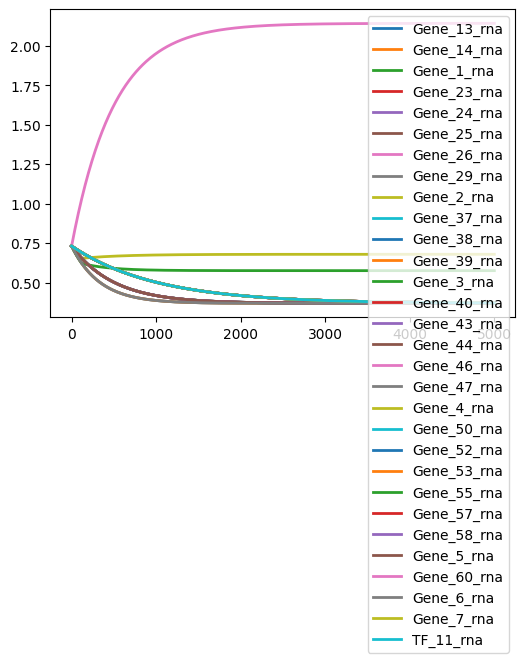

In [7]:
# Load and simulate the model
r = te.loada(antimony_model)
result = r.simulate(0, 5000, 500, ["time"] + sorted(rna_species_set))
r.plot()